In [ ]:
import os
import sys
import time
import joblib
import numpy as np
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense,
    LeakyReLU, ReLU
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

MODEL_DIR = os.path.join('..', '..', 'models')
DATA_ROOT_KAGGLE = os.path.join('..', '..', 'data_subsets', 'fire_dataset')
TEST_EVAL_DATA_ROOT = os.path.join('..', '..', 'data_subsets', 'fire_dataset')

def is_kaggle_image_fire(image_path):
    parent_dir = os.path.basename(os.path.dirname(image_path))
    return parent_dir == 'fire_images'

def load_prep_4_cnn(data_dir, target_size=(128, 128)):
    all_images = []
    all_labels = []
    class_dirs = {'fire_images': 1, 'non_fire_images': 0}

    for class_name, label in class_dirs.items():
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path): continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')): continue
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, target_size)
                img_normalized = img_resized.astype(np.float32) / 255.0
                all_images.append(img_normalized)
                all_labels.append(label)
            except Exception as e: continue
    return np.array(all_images), np.array(all_labels)

def load_all_artifacts(dataset_choice):
    print(f"\n--- Loading saved CNN model for {dataset_choice} dataset ---")
    artifacts = {}
    try:
        artifacts['cnn_model'] = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'Kaggle_cnn_best_model.keras'))
        print(f"Loaded CNN model: Kaggle_cnn_best_model.keras")
    except Exception as e: return None
    return artifacts

def fetch_original_test_split_for_cnn(data_root, target_size=(128, 128), test_size=0.2, random_state=42):
    print(f"\n--- Fetching original test split from '{data_root}' ---")
    all_images, all_labels = load_prep_4_cnn(data_root, target_size)

    if all_images.size == 0: return None, None

    X_train, X_test, y_train, y_test = train_test_split(
        all_images, all_labels, test_size=test_size, random_state=random_state, stratify=all_labels
    )
    print(f"Successfully recreated test split with {X_test.shape[0]} samples.")
    return X_test, y_test

def preprocess_image_for_cnn(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None: return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized.astype(np.float32) / 255.0

    return np.expand_dims(img_normalized, axis=0)

def evaluate_folder(folder_path, artifacts):
    print(f"\n--- Processing images in folder: {folder_path} using CNN ---")
    cnn_model = artifacts['cnn_model']
    if cnn_model is None: return

    all_true_labels = []
    all_predictions = []
    processed_count = 0

    if not os.path.isdir(folder_path): return

    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    if not image_paths: return

    for image_path in tqdm(image_paths, desc="Processing folder images"):
        base_dir_name = os.path.basename(os.path.dirname(image_path))
        true_label = 1 if 'fire_images' in base_dir_name.lower() else 0

        img_preprocessed = preprocess_image_for_cnn(image_path)
        if img_preprocessed is None: continue

        try:
            prediction_proba = cnn_model.predict(img_preprocessed, verbose=0)
            prediction = (prediction_proba > 0.5).astype(int)[0][0]

            all_true_labels.append(true_label)
            all_predictions.append(prediction)
            processed_count += 1
        except Exception as e:
            print(f"Error during prediction for {image_path}: {e}")
            continue

    print(f"\nProcessed {processed_count} images from the folder.")

    if not all_true_labels:
        print("No successful predictions for folder.")
        return

    y_true = np.array(all_true_labels)
    y_pred = np.array(all_predictions)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"\n--- Performance for CNN on Folder Data ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

def process_single_image(image_path, artifacts):
    print(f"\n--- Processing single image: {image_path} ---")
    cnn_model = artifacts['cnn_model']
    if cnn_model is None: return

    img_display = cv2.imread(image_path)
    if img_display is None: return

    base_dir_name = os.path.basename(os.path.dirname(image_path))
    true_label_text = 'Fire' if 'fire_images' in base_dir_name.lower() else 'Non-Fire'
    true_label_num = 1 if 'fire_images' in base_dir_name.lower() else 0

    img_preprocessed = preprocess_image_for_cnn(image_path)
    if img_preprocessed is None: return

    try:
        prediction_proba = cnn_model.predict(img_preprocessed, verbose=0)
        prediction = (prediction_proba > 0.5).astype(int)[0][0]
        prediction_text = "Fire" if prediction == 1 else "Non-Fire"
        print(f"True Label: {true_label_text} ({true_label_num})")
        print(f"CNN Prediction: {prediction_text}")
    except Exception as e: return

    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {os.path.basename(image_path)}\nTrue: {true_label_text}\nCNN Prediction: {prediction_text}")
    plt.axis('off')
    plt.show()

def reproduce_original_test_results(artifacts, dataset_root):
    print("\n--- Reproducing Original Test Set Results using train_test_split ---")

    cnn_model = artifacts['cnn_model']
    if cnn_model is None: return

    X_sample_test, y_sample_test = fetch_original_test_split_for_cnn(
        dataset_root,
        target_size=(128, 128),
        test_size=0.2,
        random_state=42
    )

    if X_sample_test is None or X_sample_test.size == 0: return

    print(f"\n--- Evaluating CNN on recreated original test data ({X_sample_test.shape[0]} samples) ---")
    try:
        prediction_proba = cnn_model.predict(X_sample_test, verbose=0)
        y_pred = (prediction_proba > 0.5).astype(int).flatten()
        accuracy = accuracy_score(y_sample_test, y_pred)
        f1 = f1_score(y_sample_test, y_pred, zero_division=0)
        print(f" - CNN Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    except Exception as e: pass


--- Loading saved CNN model for kaggle dataset ---
Loaded CNN model: Kaggle_cnn_best_model.keras

--- Reproducing Original Test Set Results using train_test_split ---

--- Fetching original test split from '..\..\data_subsets\fire_dataset' ---
Successfully recreated test split with 200 samples.

--- Evaluating CNN on recreated original test data (200 samples) ---
 - CNN Accuracy: 0.8900, F1: 0.9313

--- Processing images in folder: ..\..\data_subsets\fire_dataset using CNN ---


Processing folder images:  85%|████████▌ | 854/999 [02:04<00:38,  3.76it/s]

Processing folder images: 100%|██████████| 999/999 [02:25<00:00,  6.88it/s]



Processed 998 images from the folder.

--- Performance for CNN on Folder Data ---
Accuracy: 0.8176
Precision: 1.0000
Recall (Sensitivity): 0.8176
F1 Score: 0.8997
Confusion Matrix:
[[  0   0]
 [182 816]]

--- Processing single image: ..\..\data_subsets\fire_dataset\fire_images\fire.1.png ---
True Label: Fire (1)
CNN Prediction: Fire


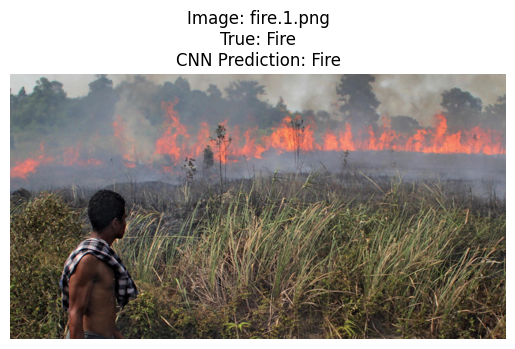


--- Processing single image: ..\..\data_subsets\fire_dataset\non_fire_images\non_fire.1.png ---
True Label: Fire (1)
CNN Prediction: Fire


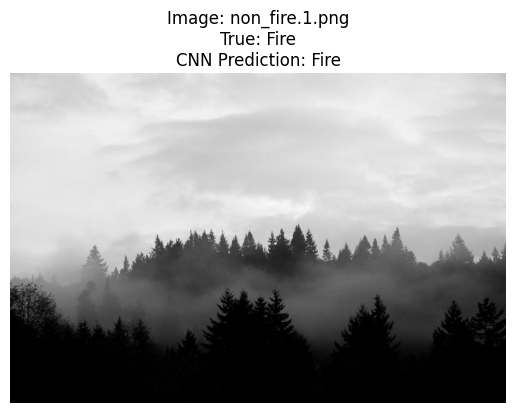

In [2]:
dataset_choice = 'kaggle'
artifacts = load_all_artifacts(dataset_choice)

if artifacts and artifacts['cnn_model'] is not None:
    reproduce_original_test_results(artifacts, DATA_ROOT_KAGGLE)
    evaluate_folder(TEST_EVAL_DATA_ROOT, artifacts) # todo replace w/ test root if needed

    fire_images_in_test_folder = [f for f in os.listdir(os.path.join(TEST_EVAL_DATA_ROOT, 'fire_images')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    non_fire_images_in_test_folder = [f for f in os.listdir(os.path.join(TEST_EVAL_DATA_ROOT, 'non_fire_images')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if fire_images_in_test_folder:
        sample_fire_image = os.path.join(TEST_EVAL_DATA_ROOT, 'fire_images', fire_images_in_test_folder[0])
        process_single_image(sample_fire_image, artifacts)
    else:
        print(f"\nNo fire images found in {os.path.join(TEST_EVAL_DATA_ROOT, 'fire_images')}. Skipping single fire image test.")

    if non_fire_images_in_test_folder:
        sample_non_fire_image = os.path.join(TEST_EVAL_DATA_ROOT, 'non_fire_images', non_fire_images_in_test_folder[0])
        process_single_image(sample_non_fire_image, artifacts)
    else:
        print(f"\nNo non-fire images found in {os.path.join(TEST_EVAL_DATA_ROOT, 'non_fire_images')}. Skipping single non-fire image test.")
else:
    print("Failed to load CNN model. Cannot proceed with testing.")